In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from torchvision.utils import make_grid

from models.flows.autoregressive import MaskedAutoregressiveFlow
from utils import load_model

FLOW_PATH = 'logs/celeba/MAF/version_7/'
MODEL_PATH = 'logs/celeba/DFCVAE/version_1/'
DATA_PATH = 'logs/celeba/DFCVAE/version_1/latent_space'

In [2]:
flow = torch.load(FLOW_PATH + 'checkpoints/model.pkt').cuda()
model = torch.load(MODEL_PATH + 'checkpoints/model.pkt').cuda()

In [3]:
def summarise(z, y):
    z = torch.tensor(z.values, dtype=torch.float).cuda()

    y0 = torch.zeros(z.shape[0], 1).cuda()
    y1 = torch.ones(z.shape[0], 1).cuda()
    
    with torch.no_grad():
        res0 = flow.log_prob(z, y0).detach().cpu().numpy()
        res1 = flow.log_prob(z, y1).detach().cpu().numpy()
        
    df = pd.DataFrame({'res0': res0, 'res1': res1, 'y': y.values[:, 0]})
    df['y_hat'] = (df['res0'] < df['res1']).astype(int)
    
    print(confusion_matrix(df['y'], df['y_hat']))
    print(classification_report(df['y'], df['y_hat']))

    
def show_image(image):
    plt.figure(figsize = (16, 8))
    plt.imshow(image.squeeze(0).permute(1, 2, 0).detach().cpu())
    plt.show()

In [4]:
z_train = pd.read_csv(f'{DATA_PATH}/z_train.csv')
y_train = pd.read_csv(f'{DATA_PATH}/y_train_gender.csv')

z_valid = pd.read_csv(f'{DATA_PATH}/z_valid.csv')
y_valid = pd.read_csv(f'{DATA_PATH}/y_valid_gender.csv')

z_test = pd.read_csv(f'{DATA_PATH}/z_test.csv')
y_test = pd.read_csv(f'{DATA_PATH}/y_test_gender.csv')

## Image

In [5]:
n_samples = 20
n_row = 5

y0 = torch.zeros(1, 1).cuda()
y1 = torch.ones(1, 1).cuda()

with torch.no_grad():
    res0 = flow.sample(n_samples, y0)
    res1 = flow.sample(n_samples, y1)

res0_image = model.decode(res0)
res1_image = model.decode(res1)

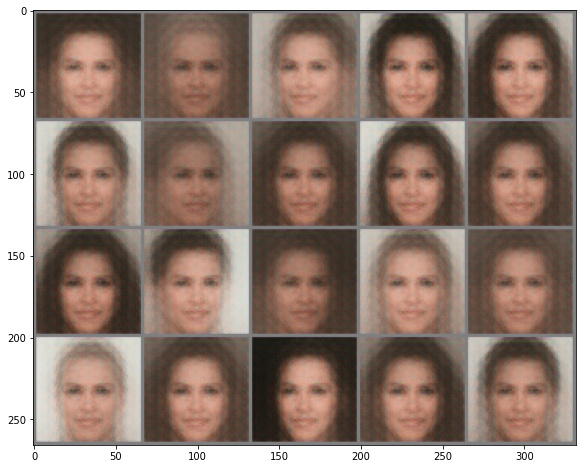

In [6]:
show_image((make_grid(res0_image, nrow = n_row) + 1) / 2)

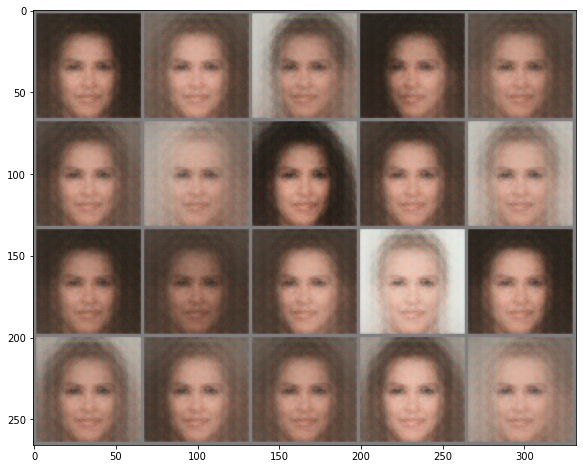

In [7]:
show_image((make_grid(res1_image, nrow = n_row) + 1) / 2)

## Classification

In [8]:
summarise(z_train, y_train)

[[84781  9728]
 [10779 57482]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     94509
           1       0.86      0.84      0.85     68261

    accuracy                           0.87    162770
   macro avg       0.87      0.87      0.87    162770
weighted avg       0.87      0.87      0.87    162770



In [9]:
summarise(z_valid, y_valid)

[[7353 4056]
 [5081 3377]]
              precision    recall  f1-score   support

           0       0.59      0.64      0.62     11409
           1       0.45      0.40      0.43      8458

    accuracy                           0.54     19867
   macro avg       0.52      0.52      0.52     19867
weighted avg       0.53      0.54      0.54     19867



In [10]:
summarise(z_test, y_test)

[[7943 4304]
 [4789 2926]]
              precision    recall  f1-score   support

           0       0.62      0.65      0.64     12247
           1       0.40      0.38      0.39      7715

    accuracy                           0.54     19962
   macro avg       0.51      0.51      0.51     19962
weighted avg       0.54      0.54      0.54     19962

